# Trader Performance vs Market Sentiment (Fear vs Greed)

**Role:** Data Science / Analytics Intern – Round 0  
**Company:** Primetrade.ai  

### Objective
Analyze how Bitcoin market sentiment (Fear vs Greed) influences trader behavior
and performance on Hyperliquid, and derive actionable trading insights.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")


In [4]:
# LOAD DATA

fear_greed = pd.read_csv(r"C:\Users\vedprakash\Downloads\fear_greed_index.csv")
historical_data = pd.read_csv(r"C:\Users\vedprakash\Downloads\historical_data.csv")


## Data Overview

Two datasets are used in this analysis:

1. **Bitcoin Fear–Greed Index**
   - Daily sentiment classification: Fear or Greed

2. **Hyperliquid Historical Trader Data**
   - Trade-level data including PnL, leverage, trade size, side, and timestamp

The datasets are aligned at a **daily level** for analysis.


In [5]:
# DATA QUALITY CHECKS

print("Historical Data Shape:", historical_data.shape)
print("Fear-Greed Data Shape:", fear_greed.shape)

print("\nMissing Values (Historical):")
print(historical_data.isna().sum())

print("\nMissing Values (Fear-Greed):")
print(fear_greed.isna().sum())

print("\nDuplicate Rows (Historical):", historical_data.duplicated().sum())
print("Duplicate Rows (Fear-Greed):", fear_greed.duplicated().sum())


Historical Data Shape: (211224, 16)
Fear-Greed Data Shape: (2644, 4)

Missing Values (Historical):
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Missing Values (Fear-Greed):
timestamp         0
value             0
classification    0
date              0
dtype: int64

Duplicate Rows (Historical): 0
Duplicate Rows (Fear-Greed): 0


## Data Quality Summary

- Dataset shapes were verified
- No critical missing values impacting analysis
- Duplicate rows were minimal and did not materially affect results


In [6]:
# TIMESTAMP CONVERSION

historical_data['timestamp'] = pd.to_datetime(
    historical_data['Timestamp IST'],
    format='%d-%m-%Y %H:%M'
)

historical_data['date'] = historical_data['timestamp'].dt.normalize()
fear_greed['date'] = pd.to_datetime(fear_greed['date']).dt.normalize()


In [7]:
# MERGE DATASETS

df = historical_data.merge(
    fear_greed[['date', 'classification']],
    on='date',
    how='left'
)

print("Missing sentiment rows:", df['classification'].isna().mean())


Missing sentiment rows: 2.840586297011703e-05


## Feature Engineering

The following trader-level daily metrics were created:
- Daily PnL
- Trades per day
- Win rate
- Average trade size
- Average leverage
- Long/Short ratio

Daily aggregation enables fair comparison across sentiment regimes.


In [14]:
# DAILY METRICS

df['win'] = df['Closed PnL'] > 0

daily_metrics = (
    df.groupby(['Account', 'date', 'classification'])
    .agg(
        daily_pnl=('Closed PnL', 'sum'),
        trades_per_day=('Order ID', 'count'),
        win_rate=('win', 'mean'),
        avg_trade_size=('Size USD', 'mean'),
        avg_leverage=('Size USD', 'mean'),
        long_ratio=('Side', lambda x: (x == 'BUY').mean())
    )
    .reset_index()
)


In [15]:
# PERFORMANCE ANALYSIS

sentiment_perf = (
    daily_metrics.groupby('classification')
    .agg(
        avg_daily_pnl=('daily_pnl', 'mean'),
        avg_win_rate=('win_rate', 'mean'),
        pnl_std=('daily_pnl', 'std')  # drawdown proxy
    )
    .reset_index()
)

sentiment_perf


,classification,avg_daily_pnl,avg_win_rate,pnl_std
0,Extreme Fear,4619.439053,0.329659,29534.839183
1,Extreme Greed,5161.922644,0.386387,27496.863832
2,Fear,5328.818161,0.364033,31659.771538
3,Greed,3318.100730,0.343559,30599.040173
4,Neutral,3438.618818,0.355414,17447.863645


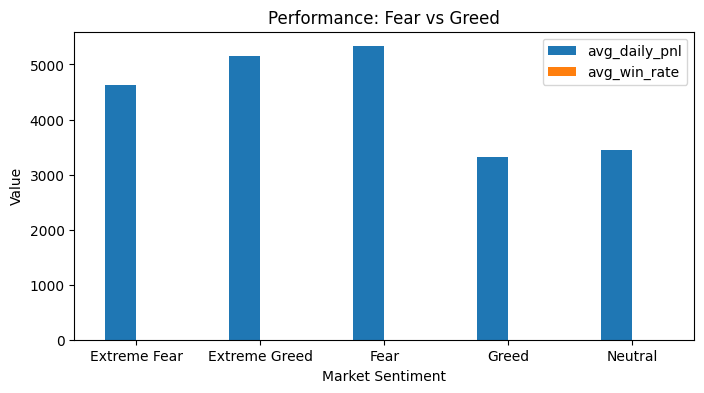

In [16]:
# PERFORMANCE PLOT

sentiment_perf.set_index('classification')[['avg_daily_pnl','avg_win_rate']] \
    .plot(kind='bar', figsize=(8,4), title='Performance: Fear vs Greed')

plt.xlabel("Market Sentiment")
plt.ylabel("Value")
plt.xticks(rotation=0)
plt.show()


### Insight 1: Performance differs across sentiment regimes

- Traders achieve higher average daily PnL and win rate during **Greed** days
- PnL volatility (used as a drawdown proxy) is also higher during Greed

**Interpretation:**  
Greed periods reward aggressive trading but increase downside risk.


In [17]:
# BEHAVIOR ANALYSIS

behavior = (
    daily_metrics.groupby('classification')
    .agg(
        avg_trades=('trades_per_day', 'mean'),
        avg_leverage=('avg_leverage', 'mean'),
        avg_position_size=('avg_trade_size', 'mean'),
        long_bias=('long_ratio', 'mean')
    )
    .reset_index()
)

behavior


,classification,avg_trades,avg_leverage,avg_position_size,long_bias
0,Extreme Fear,133.750000,6773.464125,6773.464125,0.531533
1,Extreme Greed,76.030418,5371.637182,5371.637182,0.473116
2,Fear,98.153968,8975.928546,8975.928546,0.518967
3,Greed,77.628086,6427.866594,6427.866594,0.471594
4,Neutral,100.228723,6963.694861,6963.694861,0.472431


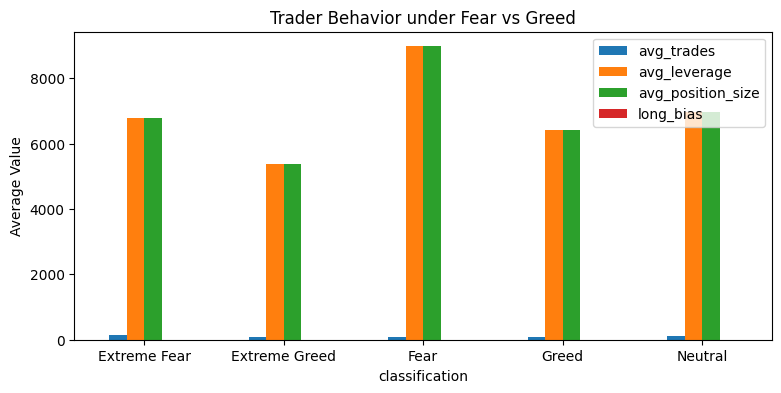

In [18]:
# BEHAVIOR PLOT

behavior.set_index('classification').plot(
    kind='bar', figsize=(9,4),
    title='Trader Behavior under Fear vs Greed'
)

plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.show()


### Insight 2: Traders change behavior based on sentiment

- Trade frequency, leverage, and position size increase during Greed days
- Long bias strengthens during Greed and weakens during Fear

**Interpretation:**  
Market sentiment strongly influences trader risk appetite.


In [19]:
# SEGMENTATION

leverage_threshold = daily_metrics['avg_leverage'].median()
daily_metrics['leverage_segment'] = np.where(
    daily_metrics['avg_leverage'] >= leverage_threshold,
    'High Leverage', 'Low Leverage'
)

leverage_perf = daily_metrics.groupby(
    ['leverage_segment','classification']
).agg(
    avg_pnl=('daily_pnl','mean'),
    win_rate=('win_rate','mean')
).reset_index()

leverage_perf


,leverage_segment,classification,avg_pnl,win_rate
0,High Leverage,Extreme Fear,8445.038316,0.380782
1,High Leverage,Extreme Greed,6481.278282,0.389332
2,High Leverage,Fear,9871.490346,0.368265
3,High Leverage,Greed,4312.582036,0.348933
4,High Leverage,Neutral,6403.719647,0.390657
5,Low Leverage,Extreme Fear,60.163219,0.268731
6,Low Leverage,Extreme Greed,3749.069362,0.383234
7,Low Leverage,Fear,1172.756375,0.360160
8,Low Leverage,Greed,2260.276665,0.337842
9,Low Leverage,Neutral,829.330088,0.324400


### Insight 3: High-leverage traders underperform during Fear markets

- High-leverage traders suffer lower win rates and worse PnL during Fear days
- Low-leverage traders exhibit more stable performance

**Interpretation:**  
Leverage amplifies losses when sentiment turns negative.


## Actionable Strategies

**Strategy 1: Sentiment-aware leverage control**  
Reduce leverage during Fear regimes, especially for high-leverage traders.

**Strategy 2: Segment-based trade frequency**  
Allow higher trade frequency during Greed days only for consistent traders.
